**By Dmitrii Khizbullin**

### SAIC-Cambridge: Distributed AI Group
## ML Engineer - Coding Challenge
Thank you for taking the time to complete this programming assignment and congratulations for reaching this stage of the interview process! 


This assignment is based on `PyTorch` and consists of 5 tasks, all based on the same *object detection* model, provided below. 
The model is obtained from `torchvision` and all code provided is just for reference purposes. You are free to change any parts of the given code, while implementing the requested features.

Keep in mind that:
- High-quality software architecture and coding practices are of high priority. Consider that the code would be used across projects in SAIC-C.
- Detection performance, end-to-end inference latency and efficiency are all of utmost importance across tasks.
- Don't forget to document any assumptions and design choices that you made and for each solution that you provide, as well as comment on its limitations.
- In case you experiment with multiple solutions for a given task, feel free to discuss all the attempts and the underlying trade-offs on your report. 

>The deliverable of this assignment is a .zip file that should include:
>- an interactive report based on a single Jupyter Notebook where all solutions/results will be clearly documented and can be reproduced; and
>- a directory with the source code that implements the assignment, following a structure of your choice.


# Reference Model

In [1]:
# !pip install ipython-autotime
# %load_ext autotime

In [ ]:
!pip install wget

In [132]:
import torch
import torchvision.transforms as T
from torchvision.models import detection
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.io.image import read_image

import cv2
import numpy as np
from PIL import Image 
import wget

In [ ]:
# Model download and setup

dev = "cuda" if torch.cuda.is_available() else "cpu"
print(dev)

model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(dev)
model.eval()

In [134]:
transforms = []
transforms.append(T.ToTensor())
#transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
transforms = T.Compose(transforms)

100% [.....................................................................] 65126 / 65126Scores: [0.9998123  0.99961084 0.9988477  0.80277795 0.7915918  0.6986016
 0.69719774 0.43758324 0.27402225 0.23157926 0.17669232 0.11194792
 0.09026063 0.08569042 0.07526258 0.06650069 0.06297987 0.05890905
 0.05836773 0.05684328 0.05646542 0.05630627]
['boxes', 'labels', 'scores']
[1, 1, 1, 27, 31, 10, 31, 47, 10, 27, 10, 75, 27, 39, 75, 27, 39, 31, 39, 73, 84, 27]
['person', 'person', 'person', 'backpack', 'handbag', 'traffic light', 'handbag', 'cup', 'traffic light', 'backpack', 'traffic light', 'remote', 'backpack', 'baseball bat', 'remote', 'backpack', 'baseball bat', 'handbag', 'baseball bat', 'laptop', 'book', 'backpack']
(255, 387, 3)


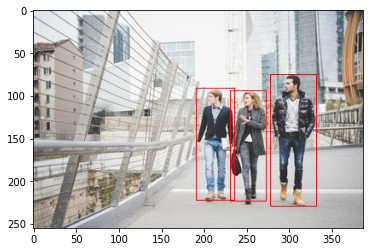

In [136]:
wget.download("https://alk15.github.io/home/files/img1.jpg")

# Prepare Image
x = Image.open('img1.jpg').convert("RGB")
x = transforms(x)
x = x.unsqueeze(0) 
x = x.to(dev)

# Run Inference
with torch.no_grad():
    prediction = model(x)[0]

# Process Output
scores = prediction["scores"].cpu().numpy()
print('Scores:', scores)
print(list(prediction.keys()))
labels = [v.item() for v in prediction['labels']]
print(labels)

# https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html#instance-segmentation-models
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

person_label = inst_classes.index('person')

print([inst_classes[v] for v in labels])

def pred_to_box(i):
    return [(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]

boxes = [pred_to_box(i)  for i in prediction['boxes'].detach().cpu()]

# Visualise Result
import matplotlib.pyplot as plt

img = Image.open('img1.jpg').convert("RGB")
img = np.array(img)
print(img.shape)
for i in range(len(boxes)):
    if inst_classes[labels[i]] == 'person':
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=500, thickness=1)

plt.imshow(img);


# Task1:
For the first task, the provided object detection model should be applied *on all frames* of a video. The model’s predictions need to be *post-processed* to return the bounding box of the **“main” person** in each frame. 

The video file for this task can be downloaded from: 
>https://alk15.github.io/home/files/london-walk.mp4


For the target application of the whole assignment, the output resolution should be `(WxH)=427x240`.

Don’t forget that end-to-end latency plays an important role in this assignment.

In [7]:
wget.download("https://alk15.github.io/home/files/london-walk.mp4")

100% [........................................................................] 10246286 / 10246286

'london-walk (1).mp4'

time: 757 ms (started: 2022-10-08 14:03:40 +00:00)


In [137]:
def batch_reader(video_path, batch_size):
    def lst_to_batch(lst):
        out_reso = (427, 240)
        lst = [cv2.resize(img, out_reso, interpolation=cv2.INTER_LINEAR)
               for img in lst]
        batch = np.array(lst)
        batch = batch[:, :, ::-1] # bgr to rgb
        batch = np.transpose(batch, (0, 3, 1, 2)) # HWC to CHW
        batch = np.ascontiguousarray(batch)
        batch = torch.tensor(batch, device=dev, dtype=torch.float32)
        batch /= 255
        return batch, lst

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open file")
        return
    frame_id = 0
    lst = []
    while True:
        ret, img = cap.read()
        if not ret:
            if len(lst) > 0:
                yield lst_to_batch(lst)
                lst = []
            break
        if len(lst) < batch_size:
            lst.append(img)
        else:
            yield lst_to_batch(lst)
            lst = []
        frame_id += 1
    cap.release()

In [144]:
%%timeit -n 1 -r 1
import time
time.sleep(0.1)

100 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [145]:
%%timeit -n 1 -r 1
all_preds = []
for batch_idx, (batch, _) in enumerate(batch_reader('london-walk.mp4', 12)):
    batch = batch.to(dev)
    if batch_idx % 10 == 0:
        print(batch_idx, batch.shape)
    with torch.no_grad():
        prediction_batch = model(batch)
        all_preds.extend(prediction_batch)
print(len(all_preds))

0 torch.Size([12, 3, 240, 427])
10 torch.Size([12, 3, 240, 427])
20 torch.Size([12, 3, 240, 427])
30 torch.Size([12, 3, 240, 427])
40 torch.Size([12, 3, 240, 427])
50 torch.Size([12, 3, 240, 427])
60 torch.Size([12, 3, 240, 427])
806
1min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


***1min 45s to analyze. Okay for T4, should be 4 times faster on V100 -> realtime*** 

In [146]:
def find_main_person(all_preds, min_score=0.9):
    all_mains = []
    for pred in all_preds:
        boxes = pred['boxes']
        labels = pred['labels']
        scores = pred['scores']
        # filter persons with the score of at least 0.9
        shortlist = [box for box, label, score in zip(boxes, labels, scores)
                     if label == person_label and score >= min_score]
        shortlist = [b.cpu().numpy() for b in shortlist]
        # find the biggest person in terms of its pixel area
        biggest = max(shortlist, key=lambda box: (box[2]-box[0])*(box[3]-box[1]))
        all_mains.append(biggest)
    return all_mains

all_mains = find_main_person(all_preds)
print(all_mains[:2])

[array([228.85417,  71.74457, 298.89966, 233.3088 ], dtype=float32), array([228.63283 ,  72.763504, 298.7618  , 232.37024 ], dtype=float32)]


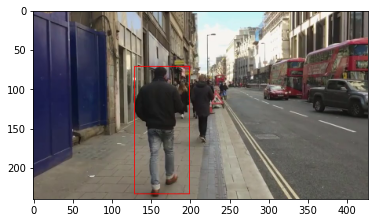

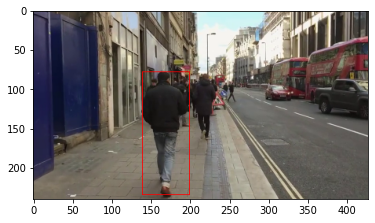

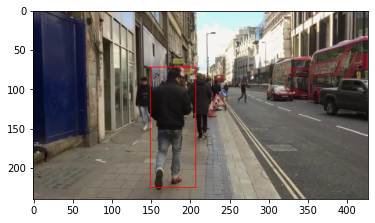

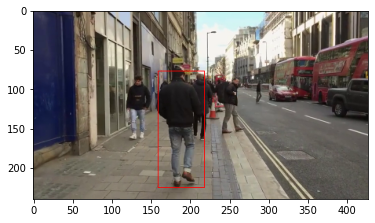

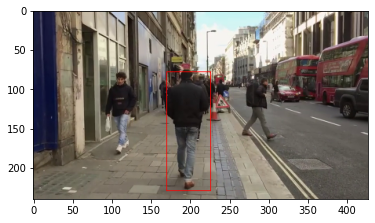

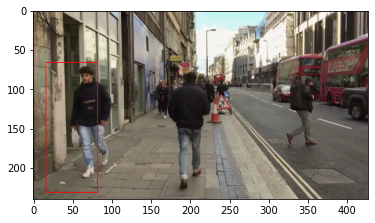

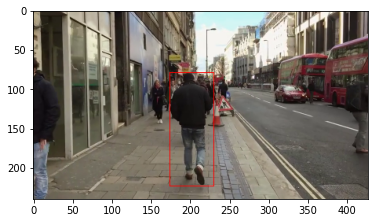

In [147]:
_, resized_imgs = next(batch_reader('london-walk.mp4', 140))
for i_frame, (img, main_bbox_pred) in enumerate(zip(resized_imgs, all_mains)):
    if i_frame % 20 != 0:
        continue
    img = np.ascontiguousarray(img[:, :, ::-1])
    main_bbox = pred_to_box(main_bbox_pred)
    main_bbox = [(img.shape[1]-x, y) for x, y in main_bbox]
    cv2.rectangle(img, main_bbox[0], main_bbox[1], color=500, thickness=1)
    plt.figure()
    plt.imshow(img)

# Task2:
For this task, you will need to quantise the above model to a precision that would maximise efficiency without significant accuracy degradation.

There is no expectation to perform any fine-tuning on the model. The use any tool (or repo) of your preference. 
If you experiment with different quantisation schemes, feel free to report all of them.


Prepare test batch

In [15]:
batch, _ = next(batch_reader('london-walk.mp4', 1))
batch = batch.to(dev)

In [14]:
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(dev)
model.eval();
model(batch);

time: 782 ms (started: 2022-10-08 14:05:00 +00:00)


In [15]:
%timeit model(batch);

128 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 10.3 s (started: 2022-10-08 14:05:02 +00:00)


## Pytorch dynamic quantization

In [16]:
model_int8 = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Conv2d},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights
model_int8.to(dev);

time: 43 ms (started: 2022-10-08 14:05:16 +00:00)


In [17]:
%timeit model_int8(batch)

130 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 10.6 s (started: 2022-10-08 14:05:17 +00:00)


No speedup from this method

## ONNXRuntime quantization

In [ ]:
torch.onnx.export(model, batch, "faster_rcnn.onnx", opset_version = 11)

In [19]:
# !pip install onnxruntime
# !pip install onnx

time: 281 µs (started: 2022-10-08 14:05:58 +00:00)


In [20]:
import onnxruntime
from onnxruntime.quantization import QuantFormat, QuantType, quantize_static
from onnxruntime.quantization import CalibrationDataReader
import numpy as np

class CustomDataReader(CalibrationDataReader):
    def __init__(self):
        self.cnt = 0

    def get_next(self):
        if self.cnt >= 10:
            return None
        self.cnt += 1
        return dict(images=np.random.rand(1, 3, 240, 427).astype(np.float32))

    def rewind(self):
        pass

dr = CustomDataReader()
quantize_static('faster_rcnn.onnx', 'faster_rcnn_quant.onnx', dr)

2022-10-08 14:06:05.330769287 [W:onnxruntime:, execution_frame.cc:594 AllocateMLValueTensorPreAllocateBuffer] Shape mismatch attempting to re-use buffer. {1,1} != {0,1}. Validate usage of dim_value (values should be > 0) and dim_param (all values with the same string should equate to the same size) in shapes in the model.
2022-10-08 14:06:05.331065231 [E:onnxruntime:, sequential_executor.cc:368 Execute] Non-zero status code returned while running Reshape node. Name:'onnx::Concat_3256_ReduceMax_Reshape' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/reshape_helper.h:41 onnxruntime::ReshapeHelper::ReshapeHelper(const onnxruntime::TensorShape&, onnxruntime::TensorShapeVector&, bool) gsl::narrow_cast<int64_t>(input_shape.Size()) == size was false. The input tensor cannot be reshaped to the requested shape. Input shape:{0,1}, requested shape:{1}



RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running Reshape node. Name:'onnx::Concat_3256_ReduceMax_Reshape' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/reshape_helper.h:41 onnxruntime::ReshapeHelper::ReshapeHelper(const onnxruntime::TensorShape&, onnxruntime::TensorShapeVector&, bool) gsl::narrow_cast<int64_t>(input_shape.Size()) == size was false. The input tensor cannot be reshaped to the requested shape. Input shape:{0,1}, requested shape:{1}


time: 6.62 s (started: 2022-10-08 14:05:58 +00:00)


Something is wrong with this converter. Dropped this direction.

## Pytorch Post-training quantization (PTQ)

Check the baseline latency

In [21]:
%timeit model(batch);

131 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 10.6 s (started: 2022-10-08 14:06:13 +00:00)


Take a look at how much the backbone takes

In [22]:
%timeit model.backbone(batch);

13.5 ms ± 42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
time: 10.9 s (started: 2022-10-08 14:06:23 +00:00)


The backbone takes just 10% of the entire latency. THus, the majority of latency goes into the RPN.

Let's try Pytorch's auto quantization

In [23]:
from torch.quantization import quantize_fx
qconfig_dict = {"": torch.quantization.default_dynamic_qconfig}  # An empty key denotes the default applied to all modules

time: 10.8 ms (started: 2022-10-08 14:06:34 +00:00)


Quantize the backbone

In [24]:
bb_quantized = quantize_fx.convert_fx(quantize_fx.prepare_fx(model.backbone, qconfig_dict))
bb_quantized.to(dev);

time: 502 ms (started: 2022-10-08 14:06:34 +00:00)


Here we get GraphModule with batchnorms fused into Conv2d 
```
GraphModule(
  (body): Module(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (relu): ReLU(inplace=True)
...
```

In [25]:
%timeit bb_quantized(batch);

13.1 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
time: 10.6 s (started: 2022-10-08 14:06:35 +00:00)


No speedup. This is suspecious

In [26]:
print(model.rpn.head)

RPNHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
)
time: 1.15 ms (started: 2022-10-08 14:06:45 +00:00)


In [27]:
rpn_prepared = quantize_fx.prepare_fx(model.rpn.head.conv, qconfig_dict)
rpn_quantized = quantize_fx.convert_fx(rpn_prepared)
rpn_quantized.to(dev);
print(rpn_quantized)

GraphModule(
  (0): Module(
    (0): ConvReLU2d(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
)



def forward(self, input):
    input_1 = input
    _0_0 = getattr(getattr(self, "0"), "0")(input_1);  input_1 = None
    return _0_0
    
time: 41.8 ms (started: 2022-10-08 14:06:45 +00:00)


In [28]:
print(model.roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
time: 546 µs (started: 2022-10-08 14:06:45 +00:00)


In [29]:
box_head_quantized = quantize_fx.convert_fx(quantize_fx.prepare_fx(model.roi_heads.box_head, qconfig_dict))
box_head_quantized.to(dev);
print(box_head_quantized)

/opt/conda/lib/python3.7/site-packages/torch/nn/quantized/_reference/modules/utils.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weight_qparams["scale"], dtype=torch.float, device=device))
/opt/conda/lib/python3.7/site-packages/torch/nn/quantized/_reference/modules/utils.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weight_qparams["zero_point"], dtype=zero_point_dtype, device=device))


GraphModule(
  (fc6): DynamicQuantizedLinearReLU(in_features=12544, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc7): DynamicQuantizedLinearReLU(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)



def forward(self, x):
    flatten = x.flatten(start_dim = 1);  x = None
    fc6 = self.fc6(flatten);  flatten = None
    fc7 = self.fc7(fc6);  fc6 = None
    return fc7
    
time: 397 ms (started: 2022-10-08 14:06:45 +00:00)


In [30]:
cls_score_quantized = quantize_fx.convert_fx(quantize_fx.prepare_fx(model.roi_heads.box_predictor.cls_score, qconfig_dict))
cls_score_quantized.to(dev);
# print(cls_score_quantized)
bbox_pred_quantized = quantize_fx.convert_fx(quantize_fx.prepare_fx(model.roi_heads.box_predictor.bbox_pred, qconfig_dict))
bbox_pred_quantized.to(dev);
# print(bbox_pred_quantized)

time: 115 ms (started: 2022-10-08 14:06:46 +00:00)


/opt/conda/lib/python3.7/site-packages/torch/fx/graph.py:1258: UserWarning: Node _packed_weight_0 target _packed_weight_0 _packed_weight_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '


Measure the baseline latency

In [71]:
%timeit model(batch);

131 ms ± 656 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Monkey-patch those modules that do not break the model

In [ ]:
import copy
model_quant = copy.deepcopy(model)
model_quant.backbone = bb_quantized
model_quant.rpn.head.conv = rpn_quantized
# model.roi_heads.box_head = box_head_quantized # this does not work
# model.roi_heads.box_predictor.cls_score = cls_score_quantized # this does not work
# model.roi_heads.box_predictor.bbox_pred = bbox_pred_quantized # this does not work
model_quant.to(dev);

In [ ]:
%timeit model_quant(batch);

No speedup compated to the baseline. The reason may be that int8 computation is not properly supported in cuDNN for T4.

In [ ]:
print(f"{model_size(model_quant):.1f} MB")

## TensoRT PTQ

TensoRT has the API to calibrate the quantization coefficients, however TRT has notoriously complicated API, so i decided to skip it

## Float16 reduced precision

In [76]:
model_half = copy.deepcopy(model)
model_half.half();

In [32]:
batch_half = batch.half()

In [74]:
%timeit model_half(batch_half)

56.6 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
127 / 56.3 

**2.25 times speedup with float16. However hte predictions are 0's for full-model float16 cast, as I checked in Task 3.**

Explanation: T4 has tensor cores and float16 is typically nicely recognized by cuDNN and tensor core kernels are run.

In [21]:
import torch.nn as nn
class LambdaModule(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        import types
        assert type(lambd) is types.LambdaType
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

To facilitate further cast to float16, let's fuse Conv2d+FrozenBatchNorm2d

In [ ]:
# https://zshn25.github.io/Layers-fusion-for-faster-inference/
from torch import nn
from torch.nn.utils.fusion import fuse_conv_bn_eval

def fuse_all_conv_bn(model):
    """
    Fuses all consecutive Conv2d and BatchNorm2d layers.
    License: Copyright Zeeshan Khan Suri, CC BY-NC 4.0
    """
    stack = []
    for name, module in model.named_children(): # immediate children
        if list(module.named_children()): # is not empty (not a leaf)
            fuse_all_conv_bn(module)
            
        if isinstance(module, nn.BatchNorm2d) or isinstance(module, torchvision.ops.misc.FrozenBatchNorm2d):
            if isinstance(stack[-1][1], nn.Conv2d):
                setattr(model, stack[-1][0], fuse_conv_bn_eval(stack[-1][1], module))
                setattr(model, name, nn.Identity())
        else:
            stack.append((name, module))

model_fused = copy.deepcopy(model)
fuse_all_conv_bn(model_fused)
print(model_fused)

In [101]:
%timeit model_fused(batch)

119 ms ± 828 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
import copy

model_half = copy.deepcopy(model_fused)
model_half.half();

In [116]:
%timeit model_half(batch_half);

53.9 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
127 / 54

2.3518518518518516

Pure float16 model is 2.35 times faster, but mmAP drops from 0.459 to 0.407

Let's cast to float16 only the backbone and RPN

In [120]:
from collections import OrderedDict

class Rpn16(nn.Module):
    def __init__(self, rpn):
        super().__init__()
        rpn = copy.deepcopy(rpn)
        rpn.half();
        self.rpn_half = rpn
    
    def forward(self, images, features, targets):
        images = images.to(torch.half)
        features = {k: v.half() for k, v in features.items()}
        targets = None
        boxes, losses = self.rpn_half(images, features, targets)
        boxes = [v.float() for v in boxes]
        losses = {k: v.float() for k, v in losses.items()}
        return boxes, losses

class Backbone16(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        backbone = copy.deepcopy(backbone)
        backbone.half();
        self.backbone_half = backbone
    
    def forward(self, image):
        image = image.to(torch.half)
        result = self.backbone_half(image)
        result = OrderedDict((k, v.float()) for k, v in result.items())
        return result

In [121]:
model_mixed = copy.deepcopy(model_fused)
model_mixed.backbone = Backbone16(model_mixed.backbone) # Not doing this since it leads to 0's in predictions
model_mixed.rpn = Rpn16(model_mixed.rpn) # monkey-patch

In [122]:
%timeit model_mixed(batch);

60.8 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
127 / 61

2.081967213114754

**A model that shows no accuracy regression compared to the float32 mode is the float16/float32 mixed model. It is 2.08x faster (!)**

In [124]:
def model_size(model):
    # https://discuss.pytorch.org/t/finding-model-size/130275
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [125]:
print(f"{model_size(model):.1f} MB")

159.7 MB


In [126]:
print(f"{model_size(model_half):.1f} MB")

79.7 MB


In [127]:
print(f"{model_size(model_mixed):.1f} MB")

107.1 MB


# Task3:
Here you should evaluate the impact of the quantisation scheme you applied in the previous task, in terms of all the aspects of model deployment that have been affected. 
Your analysis can be reported at the presentation format of your choice.


In [ ]:
!pip install pycocotools

In [ ]:
import torchvision
dataset_test = torchvision.datasets.CocoDetection(
    "/home/newuser/coco/val2017",
    "/home/newuser/coco/annotations/instances_val2017.json",
    transform=T.Compose([T.PILToTensor(), T.Lambda(lambda x: x.float() / 255)]))

In [ ]:
from pycocotools.coco import COCO
coco_gt = COCO("/home/newuser/coco/annotations/instances_val2017.json")

In [149]:
from coco_eval import CocoEvaluator
for uut in (model_half, model_mixed, model):
    print("----------- {} ----------------".format({
        model_mixed: 'model_mixed',
        model_half: 'model_half',
        model: 'model',
        }[uut]))
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0)
    coco_evaluator = CocoEvaluator(coco_gt, ["bbox"])
    for idx, (images, targets) in enumerate(data_loader_test):
            images = list(img.to(dev) for img in images)
            if uut == model_half:
                images = list(img.half() for img in images)
                pass
            with torch.no_grad():
                outputs = uut(images)
            outputs = [{k: v.to('cpu').float() for k, v in t.items()} for t in outputs]
            # if idx == 0:
            #     print(outputs)
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
            if idx > 100:
                break
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

----------- model_half ----------------
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.675
 Average Rec

No accuracy loss for the mixed float16/float32 model

# Task4:
For this task, wrap the above model so it can read incoming frames from a *webcam stream* and broadcast the results using the *MQTT protocol*. The provided solution should be able to work out-of-the-box across different systems. Inference latency remains important.


I install mosquitto MQTT broker on the host system

In [ ]:
!sudo apt install -y mosquitto

In [ ]:
!sudo systemctl status mosquitto

```
● mosquitto.service - Mosquitto MQTT v3.1/v3.1.1 Broker
   Loaded: loaded (/lib/systemd/system/mosquitto.service; enabled; vendor preset: enabled)
   Active: active (running) since Sat 2022-10-08 20:35:33 UTC; 1min 1s ago
     Docs: man:mosquitto.conf(5)
           man:mosquitto(8)
 Main PID: 4756 (mosquitto)
    Tasks: 1 (limit: 4915)
   Memory: 1.1M
   CGroup: /system.slice/mosquitto.service
           └─4756 /usr/sbin/mosquitto -c /etc/mosquitto/mosquitto.conf

Oct 08 20:35:33 saic-interview-vm systemd[1]: Starting Mosquitto MQTT v3.1/v3.1.1 Broker...
Oct 08 20:35:33 saic-interview-vm systemd[1]: Started Mosquitto MQTT v3.1/v3.1.1 Broker.
```

Then run the web cam reader, FasterRCNN and MQTT publisher via paho.mqtt. Image is base64 encoded and bundled with the bbox predictions in json format. See task4/pyblisher.py.

```
python publisher.py
Connected to MQTT Broker!
Send `['frame_id', 'image_base64', 'prediction']` to topic `webcam-detections`
Send `['frame_id', 'image_base64', 'prediction']` to topic `webcam-detections`
Send `['frame_id', 'image_base64', 'prediction']` to topic `webcam-detections`
Send `['frame_id', 'image_base64', 'prediction']` to topic `webcam-detections`
Exiting
```

To make it a nicely deployable service, I've made a Dockerfile (task4/Dockerfile)

```bash
cd task4
docker build . -t dmitrii/publisher
```

```bash
docker run dmitrii/publisher
```

# Task5:
For the final task, develop a client-server distributed system, where the results of the detection model are transmitted to the server (residing on the same machine). On the server side, the object detection results should be visualised through a web interface of your choice. Fancy graphic design is not required. 


See task5/subscriber.py

Launch
```bash
python subscriber.py
```

```
127.0.0.1 - - [09/Oct/2022 13:33:04] "GET / HTTP/1.1" 200 -
do_GET
Received `410071` bytes from `webcam-detections` topic
enqueued
dequeued
got msg 345
biggest [58.91270446777344, 22.17423439025879, 363.8713073730469, 238.48072814941406]
127.0.0.1 - - [09/Oct/2022 13:33:05] "GET / HTTP/1.1" 200 -
do_GET
do_GET
Empty queue
127.0.0.1 - - [09/Oct/2022 13:33:05] "GET /favicon.ico HTTP/1.1" 200 -
```

Live streaming results:

![title](streaming_success.png)

All done!